In [1]:
#preprocessing permite trabajar el minmaxscaler
from sklearn import preprocessing
# mse para calcular el mse
from sklearn.metrics import mean_absolute_error
#load_model para leer el modelo :v
from keras.models import load_model
#jolib permite leer el scaler que se usó para y
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# lee el modelo
f1 = load_model('lstm.h5')
f2 = load_model('lstms.h5')
f5 = load_model('grus.h5')
# lee el scaler
scaler = joblib.load('scaler.save')
# presenta la arquitectura del modelo
f2.summary()

C:\Users\Jergb\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Definir un algoritmo para acomodar los datos entrada al formato de la RNN
Y mostrar resultados :v 

### Se tiene que crear un scaler para los datos, hacer la predicción y luego invertir el scaler.
A ver cómo mola

# Si aparece un faltante se llena con el anterior Vamos a ir depurando los dato y almacenandolos :D

Vamo a revisar lo que hicimos antes para bajar desde SQL
Acá va a tocar subir a firebase y recogerlos :D
PEro primero crear un script que permita ir leyendo de a poco, pa ir formando el algoritmo :D

In [2]:
def bajar():
    'Consulta filas de la tabla "mediciones" en la base de datos de la red.'
    global WSN, fila
    fila = str(fila)
    motor = 'mysql+pymysql://root:@localhost:3306/WSN'
    engine = sqlalchemy.create_engine(motor)
    if pd.read_sql_query('select * from medidas where IDMEDIDA ='
                         + fila, engine).empty == 0:
        WSN = WSN.append(pd.read_sql_query('select * from medidas\
                         where IDMEDIDA ='+fila, engine), ignore_index=True)

        if len(WSN) == 1:
            WSN = pd.DataFrame([WSN.iloc[0, :]]).append(WSN, ignore_index=True)
            WSN.loc[0, 'TIME'] = WSN.loc[0, 'TIME'] - timedelta(seconds=60)
            WSN.loc[0, 'NODO'] = 0

        fila = int(fila) + 1
        return


def bajarprueba():
    global WSN, fila
    fila = str(fila)
    motor = 'mysql+pymysql://root:@localhost:3306/WSN'
    engine = sqlalchemy.create_engine(motor)
    if pd.read_sql_query('select * from pruebatabla where ID ='
                         + fila, engine).empty == 0:
        WSN = WSN.append(pd.read_sql_query('select * from pruebatabla\
                         where ID ='+fila, engine), ignore_index=True)

        if len(WSN) == 1:
            WSN = pd.DataFrame([WSN.iloc[0, :]]).append(WSN, ignore_index=True)
            WSN.loc[0, 'TIME'] = WSN.loc[0, 'TIME'] - timedelta(seconds=60)
            WSN.loc[0, 'NODO'] = 0

        fila = int(fila) + 1
        return

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 6 columns):
TIME                    18846 non-null object
TEMPERATURA             18846 non-null int64
HUMEDAD RELATIVA        18846 non-null int64
HUMEDAD DE LA TIERRA    18846 non-null float64
NIVEL UV                18846 non-null int64
INTENSIDAD LUMÍNICA     18846 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 883.5+ KB


None

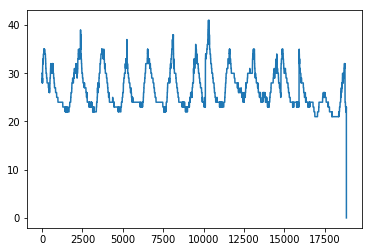

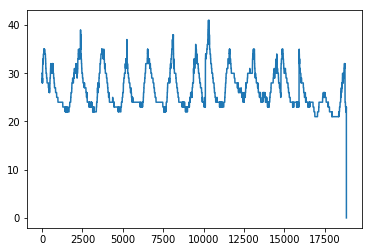

In [3]:
#a = pd.DataFrame({'a':[24,24,24,29,25,25,25,25,29,25,25,26,26,26,27,27,27,26]})
#a = pd.read_csv('nodo2_periodo2.csv')

a = pd.read_csv('medidas_nodo3.csv')

display(a.info())
a = a.loc[:,'TEMPERATURA']
a.plot()
plt.figure()
a = a.ffill().bfill()

a.plot()

In [4]:
ventana = 5
d = pd.DataFrame(index=range(len(a)))
for i in range(ventana):
    d[i] = a.shift(i+1)
d = d.dropna()
display(d.head())
display(d.tail())

,0,1,2,3,4
5,30.0,30.0,30.0,30.0,30.0
6,30.0,30.0,30.0,30.0,30.0
7,29.0,30.0,30.0,30.0,30.0
8,29.0,29.0,30.0,30.0,30.0
9,28.0,29.0,29.0,30.0,30.0


,0,1,2,3,4
18841,23.0,23.0,23.0,23.0,23.0
18842,23.0,23.0,23.0,23.0,23.0
18843,23.0,23.0,23.0,23.0,23.0
18844,23.0,23.0,23.0,23.0,23.0
18845,0.0,23.0,23.0,23.0,23.0


In [5]:
# Se define un scaler para los datos de entrada
scaler_p = preprocessing.MinMaxScaler(feature_range=(0,1))

In [6]:
# PAsa los datos a un arreglo de floats64 y los normaliza
p = np.array(d).reshape((len(d),5))
p = scaler_p.fit_transform(p)

In [7]:
# Ajusta los datos a la forma de entrda del modelo
p = np.array(p).reshape(len(p),5,1)

In [8]:
p1 = f1.predict(p)
p1 = scaler.inverse_transform(np.array(p1).reshape(len(p1),1))


In [9]:
# Realiza la predicción e invierte la escala
p2 = f2.predict(p)
p2 = scaler.inverse_transform(np.array(p2).reshape(len(p2),1))

In [10]:
# Realiza la predicción e invierte la escala
p5 = f5.predict(p)
p5 = scaler.inverse_transform(np.array(p5).reshape(len(p5),1))

In [11]:
lon = p2.shape[0]
entrada = np.array(a)[ventana:lon+ventana].reshape(lon,1)

In [12]:
# Calcula el RMSE
rmse_l = mean_absolute_error(p1, entrada)
rmse_ls = mean_absolute_error(p2, entrada)
rmse_g = mean_absolute_error(p5, entrada)

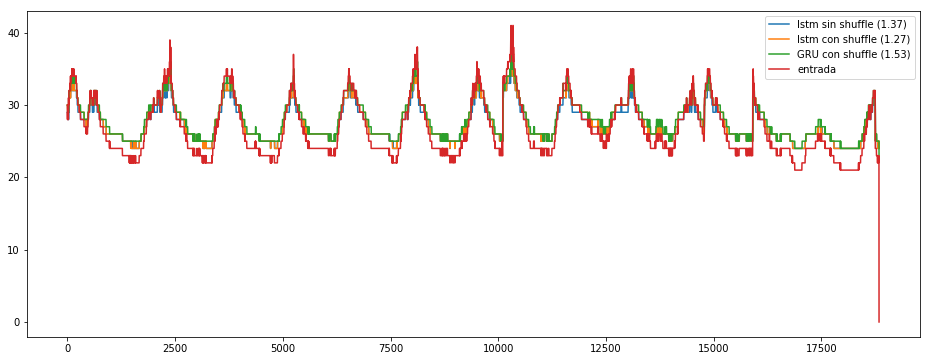

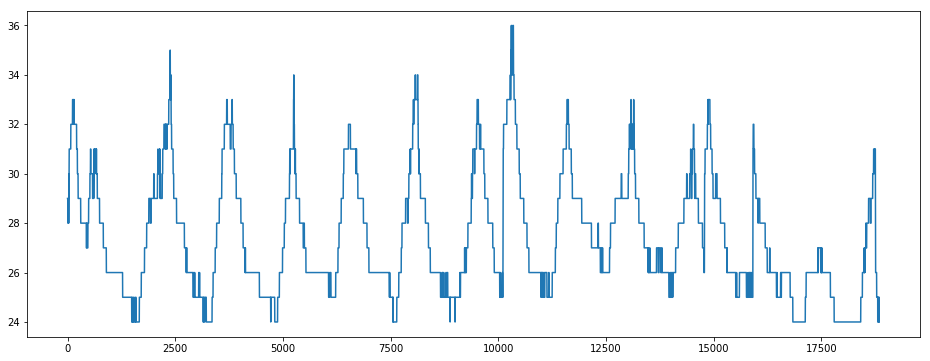

In [13]:
plt.figure(figsize=[16,6])
plt.plot(np.rint(p1),label='lstm sin shuffle (%.2f)'%rmse_l)
plt.plot(np.rint(p2),label='lstm con shuffle (%.2f)'%rmse_ls)
plt.plot(np.rint(p5),label='GRU con shuffle (%.2f)'%rmse_g)
plt.plot(entrada,label='entrada')
plt.legend()
plt.figure(figsize=[16,6])
plt.plot(np.rint(p1),label='lstm sin shuffle (%.2f)'%rmse_l)




In [14]:
VAmo a probar con todos los datos a ve qué pasa y también probar metiendo los datos uno a uno ;D

SyntaxError: invalid syntax (<ipython-input-14-492349f33dba>, line 1)

In [ ]:
Será quemetemos la tendencia como dato de entrada? 
VAmo a mirar la regularización y :
    # Ojo, el man habló de la tendencia, trate de meter eso en su modelo......